— Zusammenfassung —
Datei: ./auswertung/freq_sr620_meas4_25MHz_09_10_25.csv
Sollfrequenz: 2.5e+07 Hz
Samples: 1000
Mittelwert: 24999501.157357 Hz (Abweichung: -498.842643 Hz = -19.953706 ppm = -0.001995 %)
Std-Abweichung: 0.557240 Hz
Min/Max: 24999499.541200 Hz / 24999502.698000 Hz
Erkannte Spalten: Zeit='timestamp', Frequenz='mean'
Processed CSV gespeichert: ./auswertung/freq_sr620_meas4_25MHz_09_10_25_processed.csv


{'N': 1000,
 'f_mean': 24999501.157356597,
 'f_std': 0.5572395230889409,
 'f_min': 24999499.5412,
 'f_max': 24999502.698,
 'err_hz': array([-499.4037, -499.4278, -499.4025, -499.3195, -499.4377, -499.4301,
        -499.4632, -499.5048, -499.5191, -499.4955, -499.5527, -499.4392,
        -499.4005, -499.4454, -499.5755, -499.4   , -499.5865, -499.5453,
        -499.5795, -499.6311, -499.5629, -499.452 , -499.4598, -499.4303,
        -499.437 , -499.4609, -499.4844, -499.5019, -499.5424, -499.5698,
        -499.491 , -499.5116, -499.5367, -499.6077, -499.6054, -499.5972,
        -499.5915, -499.5986, -499.6   , -499.5847, -499.5704, -499.5417,
        -499.5622, -499.5295, -499.46  , -499.4509, -499.4319, -499.3961,
        -499.3711, -499.2875, -499.3216, -499.3555, -499.2786, -499.3125,
        -499.2663, -499.2573, -499.3184, -499.3133, -499.242 , -499.1838,
        -499.148 , -499.0861, -498.9963, -498.9872, -498.9868, -498.8864,
        -498.8521, -498.86  , -498.8438, -498.8425, -4

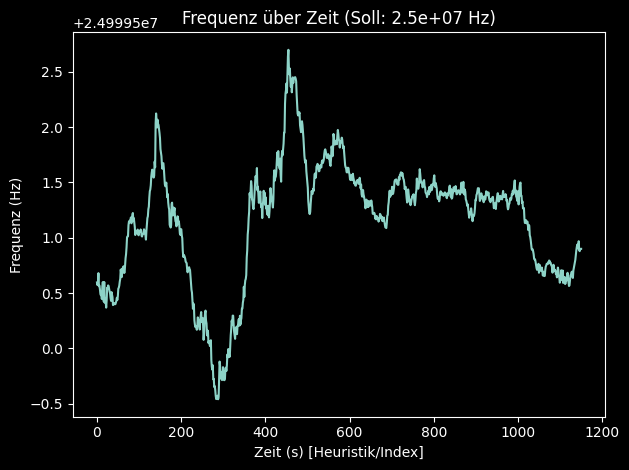

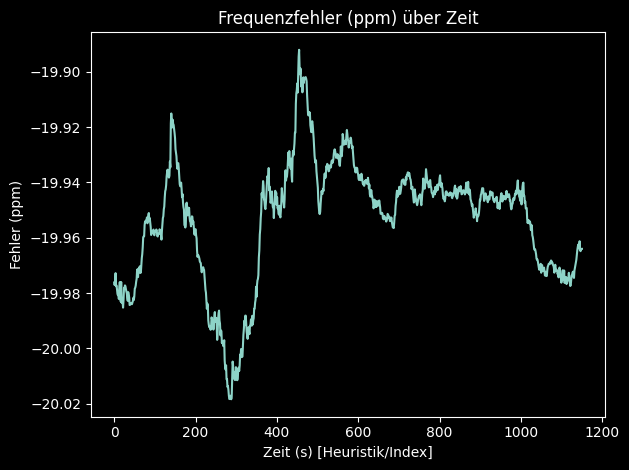

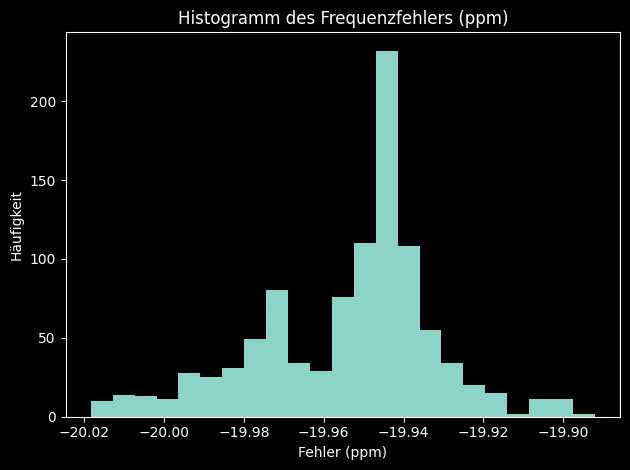

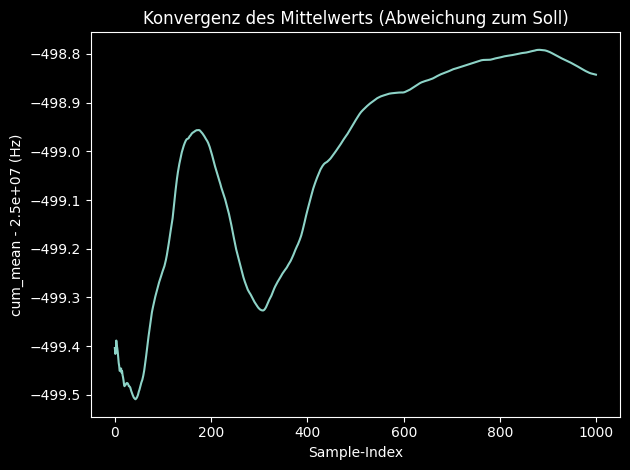

In [15]:
# SR620-Analyse & Plots für Jupyter (nur matplotlib, keine Styles/Farben)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
save_directory = './auswertung/plots_freq_10MHz'
def read_csv_robust(path, sep=None, decimal=None):
    read_kwargs = dict(engine="python")
    if sep is not None:
        read_kwargs["sep"] = sep
    if decimal is not None:
        read_kwargs["decimal"] = decimal
    if sep is not None or decimal is not None:
        return pd.read_csv(path, **read_kwargs)

    # Varianten probieren
    variants = [
        dict(sep=None, decimal="."),
        dict(sep=None, decimal=","),
        dict(sep=";", decimal=","),
        dict(sep=",", decimal="."),
        dict(sep="\t", decimal="."),
    ]
    last_err = None
    for v in variants:
        try:
            df = pd.read_csv(path, **read_kwargs, **v)
            if df.shape[1] >= 1 and len(df) > 0:
                return df
        except Exception as e:
            last_err = e
    raise RuntimeError(f"CSV konnte nicht gelesen werden: {last_err}")

def guess_columns(df):
    df.columns = [str(c).strip() for c in df.columns]
    time_keywords = ["time", "zeit", "sec", "s", "timestamp", "date", "ms", "us", "ns"]
    freq_keywords = ["freq", "frequency", "frequenz", "hz", "f"]

    def is_num(s): return pd.api.types.is_numeric_dtype(s)

    time_col = None
    for c in df.columns:
        if any(k in c.lower() for k in time_keywords):
            time_col = c; break

    freq_col = None
    for c in df.columns:
        if any(k in c.lower() for k in freq_keywords) and is_num(df[c]):
            freq_col = c; break

    if freq_col is None:
        for c in df.columns:
            if c != time_col and is_num(df[c]):
                freq_col = c; break
    if freq_col is None and df.shape[1] == 1 and is_num(df.iloc[:,0]):
        freq_col = df.columns[0]
    return time_col, freq_col

def extract_time_vector(df, time_col):
    if time_col is None:
        return np.arange(len(df), dtype=float), "Index"
    t_raw = df[time_col]
    # datetime -> Sekunden ab Start
    try:
        t_dt = pd.to_datetime(t_raw, errors="raise", dayfirst=True)
        t = (t_dt - t_dt.iloc[0]).dt.total_seconds().to_numpy()
        return t, time_col
    except Exception:
        pass
    # numerisch
    try:
        t_num = pd.to_numeric(t_raw, errors="coerce")
        return t_num.to_numpy(), time_col
    except Exception:
        return np.arange(len(df), dtype=float), "Index"

def compute_metrics(f, f0):
    N = len(f)
    f_mean = float(np.mean(f)) if N else float("nan")
    f_std  = float(np.std(f, ddof=1)) if N>1 else float("nan")
    f_min  = float(np.min(f)) if N else float("nan")
    f_max  = float(np.max(f)) if N else float("nan")
    err_hz = f - f0
    err_ppm = err_hz / f0 * 1e6
    err_mean_hz = float(np.mean(err_hz)) if N else float("nan")
    err_mean_ppm = float(np.mean(err_ppm)) if N else float("nan")
    err_percent = err_mean_ppm * 1e-4  # 1 ppm = 0.0001 %
    cum_mean = np.cumsum(f) / (np.arange(N) + 1)
    return dict(N=N, f_mean=f_mean, f_std=f_std, f_min=f_min, f_max=f_max,
                err_hz=err_hz, err_ppm=err_ppm,
                err_mean_hz=err_mean_hz, err_mean_ppm=err_mean_ppm,
                err_percent=err_percent, cum_mean=cum_mean)

def save_processed_csv(path_out, t, f, err_hz, err_ppm, cum_mean):
    pd.DataFrame({
        "t": t,
        "f_Hz": f,
        "error_Hz": err_hz,
        "error_ppm": err_ppm,
        "cum_mean_Hz": cum_mean
    }).to_csv(path_out, index=False)

def plot_all(t, f, err_ppm, cum_mean, f0, base="plot",save_png=True):
    # 1) f(t)
    plt.figure()
    plt.plot(t, f)
    plt.xlabel("Zeit (s) [Heuristik/Index]")
    plt.ylabel("Frequenz (Hz)")
    plt.title(f"Frequenz über Zeit (Soll: {f0:g} Hz)")
    plt.tight_layout()
    if save_png:
        plt.savefig(
           f"{save_directory}/freq_over_time.png", dpi=600,
                    )
    # 2) ppm(t)
    plt.figure()
    plt.plot(t, err_ppm)
    plt.xlabel("Zeit (s) [Heuristik/Index]")
    plt.ylabel("Fehler (ppm)")
    plt.title("Frequenzfehler (ppm) über Zeit")
    plt.tight_layout()
    if save_png:
         plt.savefig(
           f"{save_directory}/ppm_over_time.png", dpi=600,
                    )
    # 3) Histogramm ppm
    plt.figure()
    plt.hist(err_ppm, bins="auto")
    plt.xlabel("Fehler (ppm)")
    plt.ylabel("Häufigkeit")
    plt.title("Histogramm des Frequenzfehlers (ppm)")
    plt.tight_layout()
    if save_png:
        plt.savefig(
           f"{save_directory}/ppm_histogramm.png", dpi=600,
                    )
    # 4) Konvergenz des Mittelwerts
    plt.figure()
    plt.plot(np.arange(len(cum_mean)), cum_mean - f0)
    plt.xlabel("Sample-Index")
    plt.ylabel(f"cum_mean - {f0:g} (Hz)")
    plt.title("Konvergenz des Mittelwerts (Abweichung zum Soll)")
    plt.tight_layout()
    if save_png:
        plt.savefig(
           f"{save_directory}/kov_mean.png", dpi=600,
                    )
def analyze_sr620(csv_path, f0, time_col=None, freq_col=None, sep=None, decimal=None,
                  save_csv=True, out_csv=None, verbose=True, save_png=True):
    df = read_csv_robust(csv_path, sep=sep, decimal=decimal)
    df.columns = [str(c).strip() for c in df.columns]
    if time_col is None or freq_col is None:
        t_guess, f_guess = guess_columns(df)
        time_col = time_col or t_guess
        freq_col = freq_col or f_guess
    t, t_name = extract_time_vector(df, time_col)

    f = pd.to_numeric(df[freq_col], errors="coerce").to_numpy()
    mask = np.isfinite(f)
    if mask.sum() == 0:
        raise RuntimeError("Frequenzspalte enthält keine gültigen Zahlen.")
    if len(t) != len(f):
        t = np.arange(len(f), dtype=float)
    t, f = t[mask], f[mask]

    m = compute_metrics(f, f0)
    if verbose:
        print("— Zusammenfassung —")
        print(f"Datei: {csv_path}")
        print(f"Sollfrequenz: {f0:g} Hz")
        print(f"Samples: {m['N']}")
        print(f"Mittelwert: {m['f_mean']:.6f} Hz "
              f"(Abweichung: {m['err_mean_hz']:.6f} Hz = {m['err_mean_ppm']:.6f} ppm "
              f"= {m['err_percent']:.6f} %)")
        print(f"Std-Abweichung: {m['f_std']:.6f} Hz")
        print(f"Min/Max: {m['f_min']:.6f} Hz / {m['f_max']:.6f} Hz")
        print(f"Erkannte Spalten: Zeit='{t_name}', Frequenz='{freq_col}'")

    if save_csv:
        out_csv = out_csv or (csv_path.rsplit(".",1)[0] + "_processed.csv")
        save_processed_csv(out_csv, t, f, m["err_hz"], m["err_ppm"], m["cum_mean"])
        if verbose:
            print(f"Processed CSV gespeichert: {out_csv}")

    plot_all(t, f, m["err_ppm"], m["cum_mean"], f0, base=csv_path)
    return m

# --- Beispiele (Dateinamen ggf. anpassen) ---
#analyze_sr620("./auswertung/freq_sr620_meas4_25MHz_09_10_25.csv", 2.5e7)
analyze_sr620("./auswertung/freq_sr620_meas4_25MHz_09_10_25.csv", 2.5e7)


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

FILE   ="runG20J19/sequenz1_run1.csv"   # anpassen
N_PINS = 14                   # fester Pin-Count

df = pd.read_csv(FILE)
voltage = pd.to_numeric(df["Voltage"], errors="coerce").to_numpy()
order   = np.argsort(voltage)
x       = voltage[order]
run_cols = [c for c in df.columns if c != "Voltage"]

for pin in range(N_PINS):
    fig, ax = plt.subplots(figsize=(16, 6))  # schön breit
    for col in run_cols:
        s = pd.to_numeric(df[col], errors="coerce").fillna(0).to_numpy(dtype=np.int64)
        y = ((s >> pin) & 1).astype(int)
        ax.plot(x, y[order], marker="o", linestyle="-", label=col)
    ax.set_title(f"Pin D{pin} – State vs. Voltage")
    ax.set_xlabel("Voltage"); ax.set_ylabel("Channel state (0/1)")
    ax.set_yticks([0, 1]); ax.set_ylim(-0.1, 1.1)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(fontsize="small", loc="upper left", bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

# === Einstellungen ===
CSV_DATEI = "runG20J19/sequenz1_run1.csv"  # anpassen
SEP = ","                        # ";" falls Semikolon
N_PINS = 14                      # z.B. data[13:0]

def bit_for_pin(vals: np.ndarray, pin: int) -> np.ndarray:
    """Extrahiert Bit pin (0/1) aus Integer-Bitmasken."""
    return ((vals >> pin) & 1).astype(int)

def erste_schaltschwelle(x: np.ndarray, y: np.ndarray) -> float | None:
    """
    Findet erste 0->1-Transition in y (nach x sortiert).
    Gibt die Spannung beim ersten 1-Punkt zurück.
    """
    # sicherstellen: x aufsteigend
    order = np.argsort(x)
    xv = x[order]
    yv = y[order]

    # Indexe, an denen 0->1 passiert (i = Index des letzten 0)
    idx = np.where((yv[:-1] == 0) & (yv[1:] == 1))[0]
    if idx.size == 0:
        return None

    i = idx[0]
    # Variante A (einfach): Schwelle = Spannung des ersten 1-Punkts
    return float(xv[i + 1])

    # Variante B (falls lieber Mitte zwischen 0/1):
    # return float(0.5 * (xv[i] + xv[i + 1]))

def main():
    pd.options.display.float_format = "{:,.6f}".format

    df = pd.read_csv(CSV_DATEI, sep=SEP)
    x = pd.to_numeric(df["Voltage"], errors="coerce").to_numpy()
    run_cols = [c for c in df.columns if c != "Voltage"]

    # pro Pin: alle Schwellen der Runs sammeln
    results = []
    for pin in range(N_PINS):
        schwellen = []
        for col in run_cols:
            mask_vals = pd.to_numeric(df[col], errors="coerce").fillna(0).to_numpy(dtype=np.int64)
            y = bit_for_pin(mask_vals, pin)
            thr = erste_schaltschwelle(x, y)
            if thr is not None:
                schwellen.append(thr)

        if len(schwellen) == 0:
            results.append({
                "Pin": pin,
                "Runs (mit Schaltschwelle)": 0,
                "Mittelwert_V": np.nan,
                "Ø-Abweichung_V": np.nan,   # mean absolute deviation
                "Max-Abweichung_V": np.nan,
                "Min_V": np.nan,
                "Max_V": np.nan,
            })
            continue

        arr = np.array(schwellen, dtype=float)
        mean_v = arr.mean()
        mad_v  = np.mean(np.abs(arr - mean_v))          # durchschnittliche Abweichung
        maxdev = np.max(np.abs(arr - mean_v))           # maximale Abweichung

        results.append({
            "Pin": pin,
            "Runs (mit Schaltschwelle)": len(arr),
            "Mittelwert_V": mean_v,
            "Ø-Abweichung_V": mad_v,
            "Max-Abweichung_V": maxdev,
            "Min_V": arr.min(),
            "Max_V": arr.max(),
        })

    res_df = pd.DataFrame(results).set_index("Pin").sort_index()
    print(res_df)

if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

# === Einstellungen ===
CSV_DATEI = "runG20J19/sequenz2_run1.csv"  # anpassen
SEP = ","                        # ";" falls Semikolon
N_PINS = 14                      # z.B. data[13:0]

def bit_for_pin(vals: np.ndarray, pin: int) -> np.ndarray:
    """Extrahiert Bit pin (0/1) aus Integer-Bitmasken."""
    return ((vals >> pin) & 1).astype(int)

def erste_schaltschwelle(x: np.ndarray, y: np.ndarray) -> float | None:
    """
    Findet erste 0->1-Transition in y (nach x sortiert).
    Gibt die Spannung beim ersten 1-Punkt zurück.
    """
    # sicherstellen: x aufsteigend
    order = np.argsort(x)
    xv = x[order]
    yv = y[order]

    # Indexe, an denen 0->1 passiert (i = Index des letzten 0)
    idx = np.where((yv[:-1] == 0) & (yv[1:] == 1))[0]
    if idx.size == 0:
        return None

    i = idx[0]
    # Variante A (einfach): Schwelle = Spannung des ersten 1-Punkts
    return float(xv[i + 1])

    # Variante B (falls lieber Mitte zwischen 0/1):
    # return float(0.5 * (xv[i] + xv[i + 1]))

def main():
    pd.options.display.float_format = "{:,.6f}".format

    df = pd.read_csv(CSV_DATEI, sep=SEP)
    x = pd.to_numeric(df["Voltage"], errors="coerce").to_numpy()
    run_cols = [c for c in df.columns if c != "Voltage"]

    # pro Pin: alle Schwellen der Runs sammeln
    results = []
    for pin in range(N_PINS):
        schwellen = []
        for col in run_cols:
            mask_vals = pd.to_numeric(df[col], errors="coerce").fillna(0).to_numpy(dtype=np.int64)
            y = bit_for_pin(mask_vals, pin)
            thr = erste_schaltschwelle(x, y)
            if thr is not None:
                schwellen.append(thr)

        if len(schwellen) == 0:
            results.append({
                "Pin": pin,
                "Runs (mit Schaltschwelle)": 0,
                "Mittelwert_V": np.nan,
                "Ø-Abweichung_V": np.nan,   # mean absolute deviation
                "Max-Abweichung_V": np.nan,
                "Min_V": np.nan,
                "Max_V": np.nan,
            })
            continue

        arr = np.array(schwellen, dtype=float)
        mean_v = arr.mean()
        mad_v  = np.mean(np.abs(arr - mean_v))          # durchschnittliche Abweichung
        maxdev = np.max(np.abs(arr - mean_v))           # maximale Abweichung

        results.append({
            "Pin": pin,
            "Runs (mit Schaltschwelle)": len(arr),
            "Mittelwert_V": mean_v,
            "Ø-Abweichung_V": mad_v,
            "Max-Abweichung_V": maxdev,
            "Min_V": arr.min(),
            "Max_V": arr.max(),
        })

    res_df = pd.DataFrame(results).set_index("Pin").sort_index()
    print(res_df)

if __name__ == "__main__":
    main()


/tmp/ipykernel_37594/2997701085.py:64: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S.%f%z format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  t_dt = pd.to_datetime(t_raw, errors="raise", dayfirst=True)


— Zusammenfassung —
Datei: ./auswertung/10000_freq_sr620_meas4_25MHz_20_10_25.csv
Sollfrequenz: 2.5e+07 Hz
Samples: 10000
Mittelwert: 24999167.744096 Hz (Abweichung: -832.255904 Hz = -33.290236 ppm = -0.003329 %)
Std-Abweichung: 1.321816 Hz
Min/Max: 24999165.688900 Hz / 24999171.120100 Hz
Erkannte Spalten: Zeit='timestamp', Frequenz='mean'
Processed CSV gespeichert: ./auswertung/10000_freq_sr620_meas4_25MHz_20_10_25_processed.csv


{'N': 10000,
 'f_mean': 24999167.74409565,
 'f_std': 1.3218156950889164,
 'f_min': 24999165.6889,
 'f_max': 24999171.1201,
 'err_hz': array([-829.4718, -829.4832, -829.5058, ..., -833.8048, -833.8246,
        -833.8336], shape=(10000,)),
 'err_ppm': array([-33.178872, -33.179328, -33.180232, ..., -33.352192, -33.352984,
        -33.353344], shape=(10000,)),
 'err_mean_hz': -832.2559043499921,
 'err_mean_ppm': -33.29023617399968,
 'err_percent': -0.0033290236173999684,
 'cum_mean': array([24999170.5282    , 24999170.5225    , 24999170.51306667, ...,
        24999167.7444104 , 24999167.74425349, 24999167.7440957 ],
       shape=(10000,))}

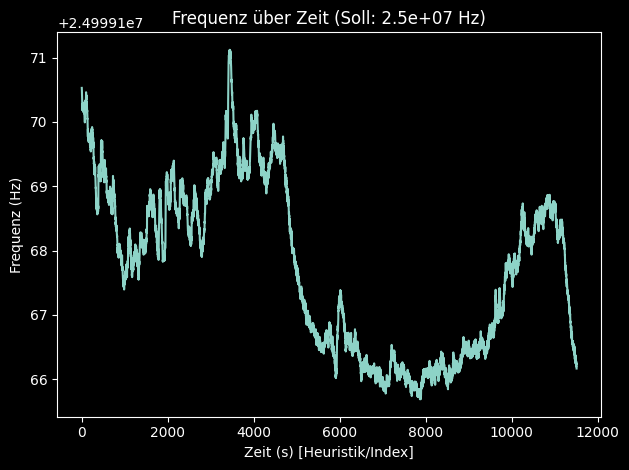

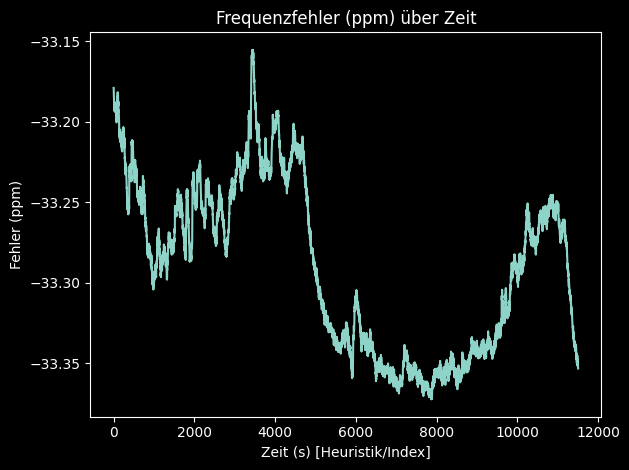

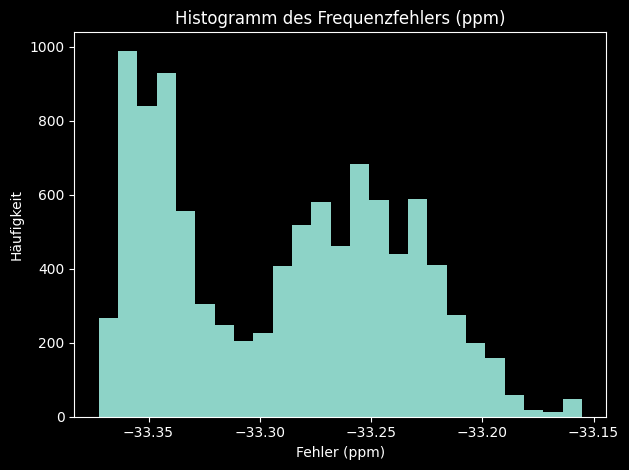

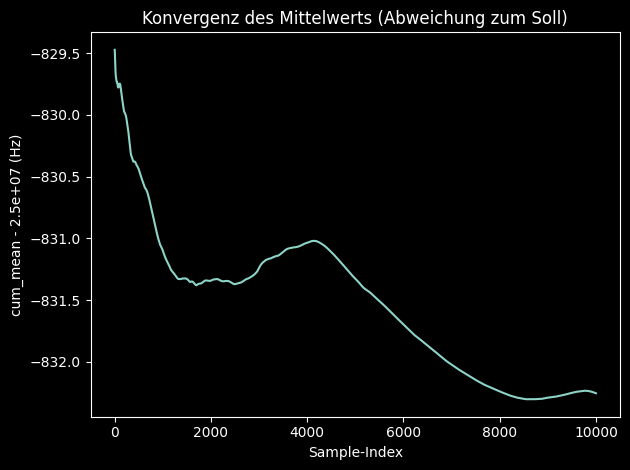

In [17]:
analyze_sr620("./auswertung/10000_freq_sr620_meas4_25MHz_20_10_25.csv", 2.5e7)